### meteostat  test 

In [ ]:
!pip install meteostat

In [1]:
import pandas as pd
import numpy as np
import meteostat as mt
import matplotlib.pyplot as plt
import datetime

In [ ]:
# Get nearby weather stations
stations = mt.Stations()
# bettystown 53.6985 , -6.2080
stations = stations.nearby(53.6985, -6.2080)
station = stations.fetch(1)

# Print DataFrame
print(station)

In [ ]:

# Set time period
start = datetime.datetime(2025, 1, 1)
end = datetime.datetime(2025, 12, 31, 23, 59)

# Get hourly data
data = mt.Hourly('03969', start, end)
data = data.fetch()

# Print DataFrame
print(data)

Fetching NASA POWER data from 20240101 to 20250801...
Data fetched successfully!

--- Sample of recent data 2023-2024 (UTC) ---
                             ghi  temp_air
timestamp                                 
2025-08-01 19:00:00+00:00  41.47     15.78
2025-08-01 20:00:00+00:00   0.00     15.15
2025-08-01 21:00:00+00:00   0.00     14.37
2025-08-01 22:00:00+00:00   0.00     13.95
2025-08-01 23:00:00+00:00   0.00     13.55

Total GHI for the past 578 days: 1708.08 kWh/m²


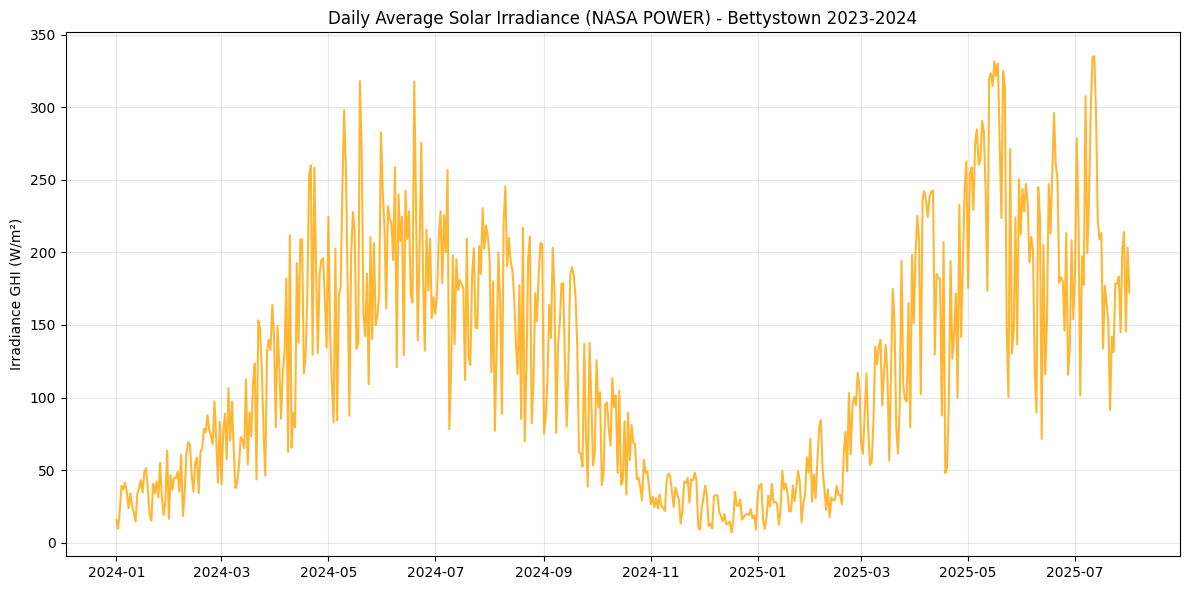

In [11]:
import requests
import pandas as pd
import io
import matplotlib.pyplot as plt

# ============================================
# 1. Define Location & Date Range
# ============================================
latitude = 53.697
longitude = -6.246
start_date = "20240101"
# Note: NASA data usually has a lag of about 3-5 days.
# Setting end date to a few days ago to ensure data availability.
end_date = "20250801"

print(f"Fetching NASA POWER data from {start_date} to {end_date}...")

# ============================================
# 2. Construct API Request URL
# ============================================
# We request Hourly data (T1H) for:
# ALLSKY_SFC_SW_DWN: All Sky Surface Shortwave Downward Irradiance (this is GHI)
# T2M: Temperature at 2 Meters
base_url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
params = {
    "parameters": "ALLSKY_SFC_SW_DWN,T2M",
    "community": "RE", # Renewable Energy
    "longitude": longitude,
    "latitude": latitude,
    "start": start_date,
    "end": end_date,
    "format": "CSV"
}

# ============================================
# 3. Fetch and Process Data
# ============================================
try:
    response = requests.get(base_url, params=params)
    response.raise_for_status() # Raise exception for bad status codes

    # The NASA CSV response has a header section we need to skip.
    # We locate the start of the actual data table.
    csv_text = response.text
    header_end_index = csv_text.find("-END HEADER-") + len("-END HEADER-\n")
    data_csv = csv_text[header_end_index:]

    # Read string data into pandas
    df = pd.read_csv(io.StringIO(data_csv))

    # Create a datetime index from Year, Month, Day, Hour columns
    df['timestamp'] = pd.to_datetime(df[['YEAR', 'MO', 'DY', 'HR']].astype(str).agg('-'.join, axis=1) + ":00", format='%Y-%m-%d-%H:%M')
    df = df.set_index('timestamp')

    # Filter out messy columns and rename to standard terms
    weather_df = df[['ALLSKY_SFC_SW_DWN', 'T2M']].rename(columns={
        'ALLSKY_SFC_SW_DWN': 'ghi',
        'T2M': 'temp_air'
    })

    # Ensure UTC timezone
    weather_df.index = weather_df.index.tz_localize('UTC')

    print("Data fetched successfully!")
    print("\n--- Sample of recent data 2023-2024 (UTC) ---")
    # GHI values are in W/m^2
    print(weather_df.tail())

    # ============================================
    # 4. Calculate Total Sun for this period
    # ============================================
    # Sum hourly W/m2 to get total Wh/m2, then convert to kWh
    total_kwh_m2 = weather_df['ghi'].sum() / 1000
    days = (weather_df.index[-1] - weather_df.index[0]).days
    print(f"\nTotal GHI for the past {days} days: {total_kwh_m2:.2f} kWh/m²")


    # Visualize GHI
    plt.figure(figsize=(12, 6))
    daily_ghi = weather_df['ghi'].resample('D').mean()
    plt.plot(daily_ghi.index, daily_ghi, color='orange', alpha=0.8)
    plt.title('Daily Average Solar Irradiance (NASA POWER) - Bettystown 2023-2024')
    plt.ylabel('Irradiance GHI (W/m²)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


except requests.exceptions.RequestException as e:
    print(f"Error fetching from NASA API: {e}")
except Exception as e:
    print(f"An error occurred processing the data: {e}")